In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFont, ImageDraw, ImageEnhance



In [2]:
i = 0
reverse_list = [0] * 8400
for hs, ws in [(80,80), (40,40), (20,20)]:
    for w in range(hs):
        for h in range(ws):
            reverse_list[i] = (int((640/hs)*(h+0.5)),int((640/ws)*(w+0.5)))
            i+=1

def convert_cwh_to_xyxy(box):
    cx, cy, w, h = box[:, :, 0], box[:, :, 1], box[:, :, 2], box[:, :, 3]
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return torch.stack((x1, y1, x2, y2), dim=2)

def generate_anchors(grid_size=0.05, dtype=torch.float32, device="cpu"):
    spatial_shapes = [[80,80], [40,40], [20,20]]
    anchors = []
    for lvl, (h, w) in enumerate(spatial_shapes):
        grid_y, grid_x = torch.meshgrid(
            torch.arange(end=h, dtype=dtype),
            torch.arange(end=w, dtype=dtype),
            indexing="ij",
        )
        grid_xy = torch.stack([grid_x, grid_y], -1)
        valid_WH = torch.tensor([w, h]).to(dtype)
        grid_xy = (grid_xy.unsqueeze(0) + 0.5) / valid_WH
        wh = torch.ones_like(grid_xy) * grid_size * (2.0**lvl)
        anchors.append(torch.concat([grid_xy, wh], -1).reshape(-1, h * w, 4))

    anchors = torch.concat(anchors, 1).to(device)
    valid_mask = ((anchors > 1e-2) * (anchors < 1 - 1e-2)).all(
        -1, keepdim=True
    )
    anchors = torch.log(anchors / (1 - anchors))
    anchors = torch.where(valid_mask, anchors, torch.inf)

    return anchors, valid_mask


def predict(input_tensor, model, detection_threshold):
    outputs = model(input_tensor)
    
    out_logits, out_bbox = outputs["pred_logits"], outputs["pred_boxes"]
    out_prob = F.softmax(out_logits, -1)
    # print(out_prob.shape)
    
    
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []

    boxes = convert_cwh_to_xyxy(out_bbox)
    for prob, box in zip(out_prob[0], boxes[0]):
        value, idx = prob.max(dim=-1)
        
        if value > detection_threshold:
            filtered_boxes.append(box.detach().cpu().tolist())
            filtered_scores.append(value.detach().cpu())
            filtered_labels.append(idx.detach().cpu())
    
    
    # prob = out_logits.sigmoid()
    # topk_values, topk_indexes = torch.topk(
    #     prob.view(out_logits.shape[0], -1), 300, dim=1
    # )
    # scores = topk_values
    # # print(scores)
    # labels = topk_indexes % out_logits.shape[2]
    # boxes = convert_cwh_to_xyxy(out_bbox)    
    
    
    # boxes = boxes[0].detach().cpu().tolist()
    # scores = scores[0].detach().cpu().tolist()
    # labels = labels[0].detach().cpu().tolist()
    
    
    # for i in range(len(scores)):
    #     if scores[i] >= detection_threshold:
    #         filtered_boxes.append(boxes[i])
    #         filtered_scores.append(scores[i])
    #         filtered_labels.append(labels[i])

    return filtered_boxes, filtered_scores, filtered_labels


    

In [3]:
def draw_boxes_plt(image, boxes, scores, labels):
    img_w, img_h = image.size
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for (xmin, ymin, xmax, ymax), score, label in zip(boxes,scores,labels):
        xmin, xmax = xmin * img_w, xmax * img_w
        ymin, ymax = ymin * img_h, ymax * img_h

        # 경계 상자 그리기
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

        # 클래스 이름과 점수 표시
        label_text = f"{label}: {score:.2f}"
        ax.text( 
            xmin,
            ymin,
            label_text,
            bbox=dict(facecolor="red", alpha=0.5),  # 텍스트 배경 추가
            fontsize=8,  # 텍스트 크기 조절
            color="w", # 텍스트 색상 변경
        )

    return fig


def draw_boxes_plt2(image, boxes, scores, labels):
    img_w, img_h = image.size

    # 레이블별로 그룹핑
    grouped_data = {}
    for i, label in enumerate(labels):
        label = int(label.item())
        if label not in grouped_data:
            grouped_data[label] = {"boxes": [], "scores": [], "labels": []}
        grouped_data[label]["boxes"].append(boxes[i])
        grouped_data[label]["scores"].append(scores[i])
        grouped_data[label]["labels"].append(labels[i])

    figs = {}  # 각 레이블별 Figure 저장

    for label, data in grouped_data.items():
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        for (xmin, ymin, xmax, ymax), score in zip(data["boxes"], data["scores"]):
            xmin, xmax = xmin * img_w, xmax * img_w
            ymin, ymax = ymin * img_h, ymax * img_h

            # 경계 상자 그리기
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

            # 클래스 이름과 점수 표시
            label_text = f"{label}: {score:.2f}"
            ax.text(
                xmin,
                ymin,
                label_text,
                bbox=dict(facecolor="red", alpha=0.5),  # 텍스트 배경 추가
                fontsize=8,  # 텍스트 크기 조절
                color="w",  # 텍스트 색상 변경
            )

        figs[label] = fig  # Figure 저장
        plt.axis("off")  # 축 제거
        # plt.title(f"Label: {label}") # title 추가
        plt.show()  # 각 label별 그래프 출력

    return figs  # 모든 Figure를 담고 있는 딕셔너리 반환

# def draw_points(input_tensor, idx, point_color=(0, 0, 255), point_size=2):
#     xs, ys = [], []
#     for i in idx:
#         x,y = reverse_list[i]
#         xs.append(x)
#         ys.append(y)

#     fig, ax = plt.subplots()

#     input_tensor = input_tensor[0].cpu()
#     image_numpy = input_tensor.permute(1, 2, 0).numpy()
#     # 이미지 배경 설정
#     ax.imshow(image_numpy)

#     # scatter plot 그리기
#     for x, y in zip(xs, ys):
#         ax.scatter(x, y, s=10, c='red', marker='o')  # s: 점 크기, c: 색깔, marker: 모양

#     # 축 범위 및 기타 설정 (optional)
#     ax.set_xlim(0, image_numpy.shape[1])
#     ax.set_ylim(image_numpy.shape[0], 0)  # y축 반전
#     ax.set_aspect('equal')  # x, y 축 비율 동일하게 설정
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.title("Points on Tensor Image")

#     plt.show()

# 모델 불러오는 파트

In [4]:
from src.solver import TASKS
from src.core import YAMLConfig

config = '/home/prml/StudentsWork/Chanyoung/MODU/configs/MODU/tiny.yml'
pt_path = '/home/prml/StudentsWork/Chanyoung/MODU/weights/tiny.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
# print(solver)

device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()

_IncompatibleKeys(missing_keys=['norm0.weight', 'norm0.bias', 'norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['head.bias', 'head.weight', 'norm.bias', 'norm.weight'])
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
resume from /home/prml/StudentsWork/Chanyoung/MODU/weights/tiny.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict


MODU(
  (backbone): ConvNeXtV2(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm()
      )
      (1): Sequential(
        (0): LayerNorm()
        (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): Sequential(
        (0): LayerNorm()
        (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
      )
      (3): Sequential(
        (0): LayerNorm()
        (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): Block(
          (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm()
          (pwconv1): Linear(in_features=96, out_features=384, bias=True)
          (act): GELU(approximate='none')
          (grn): GRN()
          (pwconv2): Linear(in_features=384, out_features=96, bias=True)
          (drop_path): Identity()
    

# 모델의 중간 피처 빼오는 파트

In [5]:
def hook_get_enc_outputs_box(module, input, output):
    global enc_outputs_coord
    enc_outputs_coord = output

def hook_get_enc_outputs_class(module, input, output):
    global enc_outputs_logit
    enc_outputs_logit = output
    
def hook_get_encoder_feature(module, input, output):
    global encoder_feature
    encoder_feature = output

In [63]:
import os
img_path = '/home/prml/Dataset/coco2017/test2017/'
img_name_list = os.listdir(img_path)
n = -1

000000508651.jpg
torch.Size([1, 3, 640, 640])


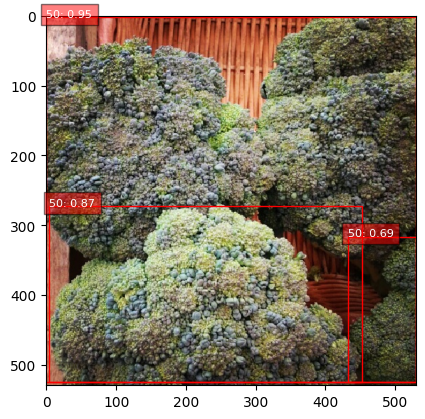

In [244]:
n += 1
print(img_name_list[n])
image = Image.open(os.path.join(img_path, img_name_list[n]))

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.eval().to(device)

# Run the model and display the detections
boxes, scores, labels = predict(input_tensor, model, 0.5)
pred_result = draw_boxes_plt(image, boxes, scores, labels)
# pred_result

In [229]:
image = Image.open(os.path.join(img_path, img_name_list[n]))
# 000000073479.jpg  000000145934.jpg  000000217976.jpg  000000290640.jpg  000000363685.jpg  000000436789.jpg  000000509803.jpg
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)


enc_outputs_box = model.decoder.enc_bbox_head
hook_1 = enc_outputs_box.register_forward_hook(hook_get_enc_outputs_box)
enc_outputs_class = model.decoder.enc_score_head
hook_2 = enc_outputs_class.register_forward_hook(hook_get_enc_outputs_class)
encoder_outputs_feature = model.encoder
hook_3 = encoder_outputs_feature.register_forward_hook(hook_get_encoder_feature)

# 모델 forward pass
output = model(input_tensor)

# Hook 제거
hook_1.remove()
hook_2.remove()
hook_3.remove()


torch.Size([1, 3, 640, 640])


# seleted query

In [230]:
enc_outputs_logit = enc_outputs_logit.cpu()

anchor, _ = generate_anchors()
enc_outputs_coord = enc_outputs_coord.cpu()
enc_outputs_coord_unact = enc_outputs_coord + anchor

topk_logits, topk_ind = torch.topk(enc_outputs_logit.max(-1).values, 300, dim=1)

_,enc_class_list = torch.max(enc_outputs_logit, dim=2)
enc_class_list = enc_class_list.squeeze(0)

reference_points_unact = enc_outputs_coord_unact.gather(
    dim=1,
    index=topk_ind.unsqueeze(-1).repeat(
        1, 1, enc_outputs_coord_unact.shape[-1]
    ),
)

# topk_ind

In [231]:
enc_class_list = enc_class_list.tolist()

In [232]:
feats_idx_logit = [[] ,[], []]
feats_idx_class = [[] ,[], []]
feats_idx_x = [[] ,[], []]
feats_idx_y = [[] ,[], []]
for i, lo in zip(topk_ind.tolist()[0][:100], topk_logits.tolist()[0][:100]):
    print(i, end=' ')
    x, y = reverse_list[i]
    
    if i < 6400:
        feats_idx_class[0].append(enc_class_list[i])
        # feats_idx_logit[0].append(lo)
        feats_idx_x[0].append(x)
        feats_idx_y[0].append(y)
    elif i < 8000:
        feats_idx_class[1].append(enc_class_list[i])
        # feats_idx_logit[1].append(enc_outputs_logit[0][i])
        feats_idx_x[1].append(x)
        feats_idx_y[1].append(y)
    else:
        feats_idx_class[2].append(enc_class_list[i])
        # feats_idx_logit[2].append(enc_outputs_logit[0][i])
        feats_idx_x[2].append(x)
        feats_idx_y[2].append(y)

8069 8270 8163 8195 8343 8042 8077 8336 8241 8150 8390 8151 8014 8266 8169 8245 8149 8172 8012 8171 8246 8265 8244 8148 8347 8005 8065 8075 8170 8147 8203 8286 8081 8348 8204 8094 8098 8013 8045 8055 8015 8054 8095 8167 8327 8082 8287 8263 8058 8274 8166 8064 8102 8264 8152 8074 8353 8101 8201 8011 8369 8352 8053 8391 8224 8187 8372 8034 8168 8093 8202 8351 8216 8085 8044 8283 8181 8073 8349 8124 8137 8035 8036 8373 8046 8138 8026 8117 8267 8173 8118 8275 8354 8155 8281 8079 8307 8116 8129 8096 

# encoder feature 확인 부분

In [233]:
print(len(encoder_feature))
print(encoder_feature[0].shape)
print(encoder_feature[1].shape)
print(encoder_feature[2].shape)

3
torch.Size([1, 256, 80, 80])
torch.Size([1, 256, 40, 40])
torch.Size([1, 256, 20, 20])


[] []


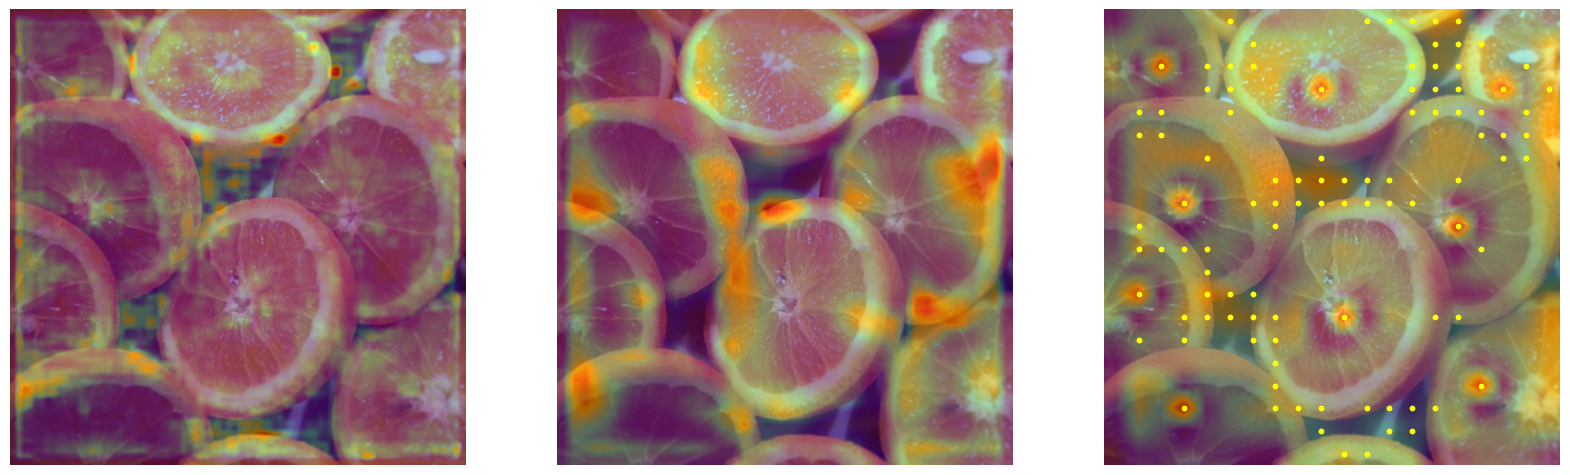

In [236]:
target_class = 49

temp_logit_0 = F.softmax(enc_outputs_logit[0][:6400].reshape(80,80,80), dim=2)
temp_logit_1 = F.softmax(enc_outputs_logit[0][6400:8000].reshape(40,40,80), dim=2)
temp_logit_2 = F.softmax(enc_outputs_logit[0][8000:].reshape(20,20,80), dim=2)


fig, axes = plt.subplots(1, 3, figsize=(20, 10))
# axes[0].axis('off')
# axes[0].imshow(image)

temp_logit_0 = temp_logit_0[:,:,target_class].detach().cpu().numpy()
temp_logit_0 = (temp_logit_0 - np.min(temp_logit_0)) / (np.max(temp_logit_0) - np.min(temp_logit_0))
temp_logit_0 = cv2.resize(temp_logit_0, (image.width,image.height), interpolation=cv2.INTER_LINEAR)
temp_logit_0 = 1-temp_logit_0
heatmap_0 = cv2.applyColorMap(np.uint8(255*temp_logit_0), cv2.COLORMAP_JET)
overlayed_image_0 = heatmap_0 *0.5 + np.array(image)
overlayed_image_0 = overlayed_image_0 / np.max(overlayed_image_0)
xs, ys = [], []
for x,y,c in zip(feats_idx_x[0], feats_idx_y[0], feats_idx_class[0]):
    if c == target_class:
        xs.append(x)
        ys.append(y)
x = np.array(xs) / 640 * image.width
y = np.array(ys) / 640 * image.height
axes[0].scatter(x, y, s=10, c='yellow', marker='o')
axes[0].imshow(overlayed_image_0)
axes[0].axis('off')

temp_logit_1 = temp_logit_1[:,:,target_class].detach().cpu().numpy()
temp_logit_1 = (temp_logit_1 - np.min(temp_logit_1)) / (np.max(temp_logit_1) - np.min(temp_logit_1))
temp_logit_1 = cv2.resize(temp_logit_1, (image.width,image.height), interpolation=cv2.INTER_LINEAR)
temp_logit_1 = 1-temp_logit_1
heatmap_1 = cv2.applyColorMap(np.uint8(255*temp_logit_1), cv2.COLORMAP_JET)
overlayed_image_1 = heatmap_1 *0.5+ np.array(image)
overlayed_image_1 = overlayed_image_1 / np.max(overlayed_image_1)
xs, ys = [], []
for x,y,c in zip(feats_idx_x[1], feats_idx_y[1], feats_idx_class[1]):
    if c == target_class:
        xs.append(x)
        ys.append(y)
x = np.array(xs) / 640 * image.width
y = np.array(ys) / 640 * image.height
print(x,y)
axes[1].scatter(x, y, s=10, c='yellow', marker='o')
axes[1].imshow(overlayed_image_1)
axes[1].axis('off')

temp_logit_2 = temp_logit_2[:,:,target_class].detach().cpu().numpy()
temp_logit_2 = (temp_logit_2 - np.min(temp_logit_2)) / (np.max(temp_logit_2) - np.min(temp_logit_2))
temp_logit_2 = cv2.resize(temp_logit_2, (image.width,image.height), interpolation=cv2.INTER_LINEAR)
temp_logit_2 = 1-temp_logit_2
heatmap_2 = cv2.applyColorMap(np.uint8(255*temp_logit_2), cv2.COLORMAP_JET)
overlayed_image_2 = heatmap_2  *0.5 + np.array(image)
overlayed_image_2 = overlayed_image_2 / np.max(overlayed_image_2)
xs, ys = [], []
for x,y,c in zip(feats_idx_x[2], feats_idx_y[2], feats_idx_class[2]):
    if c == target_class:
        xs.append(x)
        ys.append(y)
x = np.array(xs) / 640 * image.width
y = np.array(ys) / 640 * image.height
axes[2].scatter(x, y, s=10, c='yellow', marker='o')
axes[2].imshow(overlayed_image_2)
axes[2].axis('off')

plt.show()

torch.Size([1, 3, 640, 640])


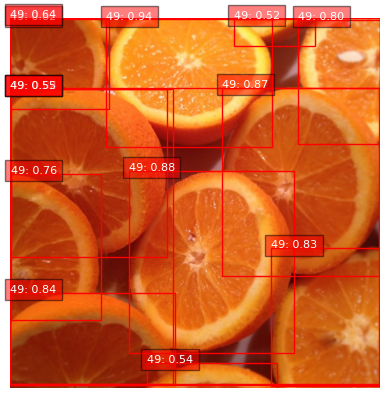

In [235]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.eval().to(device)

# Run the model and display the detections
boxes, scores, labels = predict(input_tensor, model, 0.5)
pred_result = draw_boxes_plt2(image, boxes, scores, labels)
# pred_result
